In [1]:
# Deep Learning Lib
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint

# Data Manipulation Lib
import numpy as np
import random

# Data Loading Lib
import json

# Visualization library
from pprint import pprint
import matplotlib.pyplot as plt

# Helper Modules
from lib.utils import *
from lib.odefunc import *

# Misc
import os
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Define some constants
ROOT_PATH = "./data"
CHECKPOINT_PATH = './checkpoint/state_dict_'
FILE_NAME = 'strogatz_extended.json'
SEED = 42
EPOCHS = 1000
N_LAYERS = 4
N_UNITS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Read dataset
with open(os.path.join(ROOT_PATH, FILE_NAME)) as strogatz:
    data = np.array(json.load(strogatz))

In [4]:
# Define model (for one 2D equation)
ode = data[26]
ode_func = ODEfunc(ode['dim'], N_LAYERS, N_UNITS, DEVICE)

# Set best loss
best_loss = float('inf')

In [5]:
def get_batch_single(ode_dim, data, t, batch_len=50, batch_size=1, device = torch.device("cpu")):
	s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_len, dtype=np.int64), batch_size, replace=False))
	data = data.reshape(-1, ode_dim)

	batch_y0 = data[s]  # (M, D)
	batch_t = t[:batch_len]  # (T)
	batch_y = torch.stack([data[s + i] for i in range(batch_len)], dim=0)  # (T, M, D)

	return batch_y0.reshape(1, -1, ode_dim).to(device), batch_t.to(device), batch_y.reshape(1, -1, ode_dim).to(device)


In [11]:
%%time 

# Define optimizer and start training
optimizer = optim.Adamax(ode_func.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9987)

# Set train_dict
train_dict = ode['solutions'][0]

# Separate required variables
X_train = torch.tensor(train_dict[0]['y'])
t = torch.tensor(train_dict[0]['t'])

# Training loop
for itr in range(EPOCHS):
    # Set required variables
    optimizer.zero_grad()
    
    # Get batches of data
    batch_y0, batch_t, batch_y = get_batch_single(2, X_train, t, batch_len=50, device = DEVICE)

    # Train the Neural ODEs
    pred_y = odeint(ode_func, batch_y0, batch_t, method = 'rk4').to(DEVICE).transpose(0,1)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    
    # print(batch_y0.shape)
    # print(batch_t.shape)
    # print(batch_y.shape)
    # print(pred_y.shape)

    # break
    
    # Print the loss
    if (itr + 1) % 20 == 0 or itr == 0:
        print(f'Epoch {itr + 1} / {EPOCHS} Loss {loss.item()}')
    
    # print(f'Epoch {itr + 1} / {EPOCHS} Loss {loss.item()}')

    
    # Save checkpoint if lesser error
    if best_loss > loss:
        best_loss = loss
        ckpt_path = CHECKPOINT_PATH + str(26) + '.ckpt'
        torch.save({'state_dict': ode_func.state_dict(),}, ckpt_path)

    # Backprop and step up
    loss.backward()
    optimizer.step()
    scheduler.step()

Epoch 1 / 1000 Loss 0.30218496918678284
Epoch 20 / 1000 Loss 2.1429200172424316
Epoch 40 / 1000 Loss 2.4128870964050293
Epoch 60 / 1000 Loss 1.3799867630004883
Epoch 80 / 1000 Loss 2.173961639404297
Epoch 100 / 1000 Loss 0.28991490602493286
Epoch 120 / 1000 Loss 2.721269130706787
Epoch 140 / 1000 Loss 0.14569441974163055
Epoch 160 / 1000 Loss 0.952124834060669
Epoch 180 / 1000 Loss 2.1661131381988525
Epoch 200 / 1000 Loss 0.1833835393190384
Epoch 220 / 1000 Loss 1.315401554107666
Epoch 240 / 1000 Loss 2.5089635848999023
Epoch 260 / 1000 Loss 3.2049057483673096
Epoch 280 / 1000 Loss 0.4204225540161133
Epoch 300 / 1000 Loss 1.953349232673645
Epoch 320 / 1000 Loss 1.180315613746643
Epoch 340 / 1000 Loss 0.15901432931423187
Epoch 360 / 1000 Loss 1.7064533233642578
Epoch 380 / 1000 Loss 2.4555583000183105
Epoch 400 / 1000 Loss 2.4318511486053467
Epoch 420 / 1000 Loss 0.28504401445388794
Epoch 440 / 1000 Loss 3.212862253189087
Epoch 460 / 1000 Loss 2.145315647125244
Epoch 480 / 1000 Loss 2.3

In [7]:
checkpoint = torch.load(CHECKPOINT_PATH + "26.ckpt")
ode_func.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
batch_y0, batch_t, batch_y = get_batch_single(2, torch.tensor(ode['solutions'][0][0]['y']), torch.tensor(ode['solutions'][0][0]['t']), batch_len=50, device = DEVICE)
batch_y0 = batch_y0.reshape(-1, 2)
pred_y = odeint(ode_func, batch_y0, batch_t).reshape(1, -1, 2)

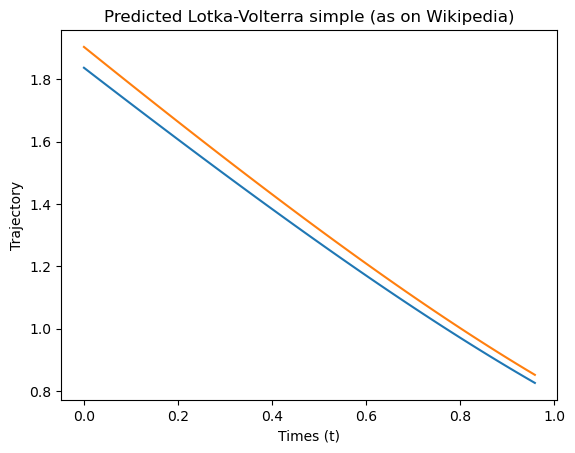

In [9]:
pred_trajectory_1 = pred_y[0][:,0]
pred_trajectory_2 = pred_y[0][:,1]

ymin = torch.min(pred_trajectory_1).detach().numpy()
ymax = torch.min(pred_trajectory_1).detach().numpy()

plt.xlabel("Times (t)")
plt.ylabel('Trajectory')
plt.plot(batch_t.detach().numpy(), pred_trajectory_1.detach().numpy())
plt.plot(batch_t.detach().numpy(), pred_trajectory_2.detach().numpy())
plt.title("Predicted " + ode.get('eq_description'))
plt.show()

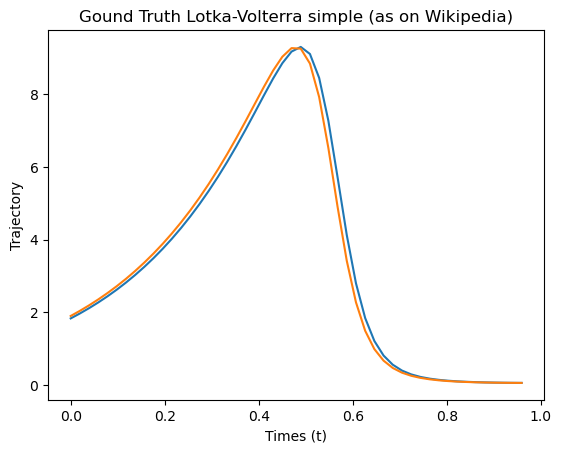

In [10]:
gt_traj_1 = batch_y[0][:,0]
gt_traj_2 = batch_y[0][:,1]

plt.xlabel("Times (t)")
plt.ylabel('Trajectory')
plt.plot(batch_t.detach().numpy(), gt_traj_1.detach().numpy())
plt.plot(batch_t.detach().numpy(), gt_traj_2.detach().numpy())
# plt.ylim(ymin, ymax)
plt.title("Gound Truth " + ode.get('eq_description'))
plt.show()
